## Modelling income with demographic data


##### Predicting individuals income using information from ```income_dataset_finalized.csv```.
---



This notebook contains all data preparation, model fitting, and statistical analysis of our model accuracies 

#### Data preprocessing

---

In order to give each model the best chance, the class labels are ordered appropriately for our predictive class explicitly using ```ordered_incomes```. The training data is automatically ordered by ```OrdinalEncoder```. 


In [1]:
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


# Change directory to csvs/
os.chdir('/Users/sb/git/UW-data-analysis-study/csvs')

# Load csv file and account for NaN entries
df = pd.read_csv('income_dataset_finalized.csv')
df.fillna("None", inplace=True)


# Create an ordered list of our class labels
ordered_incomes= [
    "Don't know/Refused",
    'Less than $10K', '$10K to under $20K',
    '$20K to under $30K','$30K to under $40K',
    '$40K to under $50K','$50K to under $75K',
    '$75K to under $100K', '$100K to under $150',
    '$150K or more'
]

def pipe_data(df,incomes=ordered_incomes):
    """ Takes in dataframe and returns:
    - X ; data for model training and validation
    - y ; labels for each row of data """
    
    # Encode training data
    encoder = OrdinalEncoder()
    X = encoder.fit_transform(df.iloc[:,1:-1])

    # Encode prediction classes with integer values
    switch = {inc:i for i,inc in enumerate(incomes)}
    map_incomes = lambda x:switch.get(x)
    y = df['Income'].apply(map_incomes).values
    return X,y

X,y = pipe_data(df)

print("Shape of training data: ", X.shape)
print("Shape of class labels: ", y.shape) 

Shape of training data:  (447, 11)
Shape of class labels:  (447,)


### Model Selection

To maximize reproducibility, the seperation of our validation data and labels is performed per instance of model fitting with a set random state $i$ in $\{n\in\mathbf{N}:n=0,1,...,199\}$

This is seperate from the random state of each model instance, which is designated only once before going through the assessment pipeline.


There are three models being evaluated here. The three with ```random_state``` arguments;
```RandomForrestClassifer```, ```DecisionTreeClassifier```, 
are instantiated with random states 1 and 2, respectively

```KNeighborsClassifier``` is deterministic and does not require a random state to be reproducible.


--


These particular models were chosen considering the relatively small size of our dataset, and the distribution of our samples across the various metrics. For example, all 50 states in the USA are present in the ```'State'``` column, and there are more than two dozen majors represented in the ```'Major'``` column.

Trees/forrests should be able to find a relationship between each row of data and its class if there is s discernable relationship between the two present.

Similarly, if we see that vectors with high cosine similarity often share labels, then a k-neighbors approach may be advantageous.


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Set number of iterations for model evaluation
N=10

def assess_model(model,i,verbose=False,X=X,y=y,**kwargs):
    """This function partitions data with random_state=i,
    trains a model using the chosen parameters,
    and returns (true labels - predictions)"""
    X_train,X_test,y_train,y_test=train_test_split(
        X,y,test_size=.1,random_state=i)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    accuracy = y_test - predictions
    score = accuracy_score(y_test,predictions)
    report = classification_report(y_test,predictions)
    if verbose:
        #print("Full Report:\n",report)
        print("Accuracy Score = {:%.5f}".format(score))
    return accuracy

def plot_hist(accuracies,title='',label=True,**kwargs):
    plt.figure(figsize=(8,5),dpi=120)
    for i,acc in enumerate(accuracies):
        if label:
            label="seed={},std={:.2f}".format(i,acc.std())
        plt.hist(acc,label=label,alpha=.2,**kwargs,
                 bins=len(np.unique(acc)));
    plt.xticks(range(-9,10))
    plt.legend(fontsize=8)
    plt.title(title)
    plt.grid(True)
    plt.show()


def get_assessment(model,n=N,verb=False,plot=False,title=''):
    """This function assesses a model n times and returns all accuracies"""
    accuracies = [assess_model(model,i,verbose=verb) for i in range(n)]
    if plot: # Plot histograms if desired
        plot_hist(accuracies,title=title)
    return accuracies

## Model Assessment

---

The assessment pipeline is as follows:

- Each model is fit on a random partition of training data/labels (```X_train```/```y_train```) 80% the size of our data
- Each model then predicts the labels for our ```X_test``` 
- We compute model ```accuracy```, which is ```predictions``` minus the true labels; ```y_test```

Each model is assessed on 200 different partitions, then the mean and standard deviation of each accuracy distribution calculated and averaged.

is close to 1, we can reliable predict income using the demographic data in question. 



In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators = 50,
    max_depth = 10,
    random_state=1,
    bootstrap=False,
#     ccp_alpha=0.2,
    class_weight='balanced',
    n_jobs=-1
)

/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/sb/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/sb/opt/anaconda3/lib/

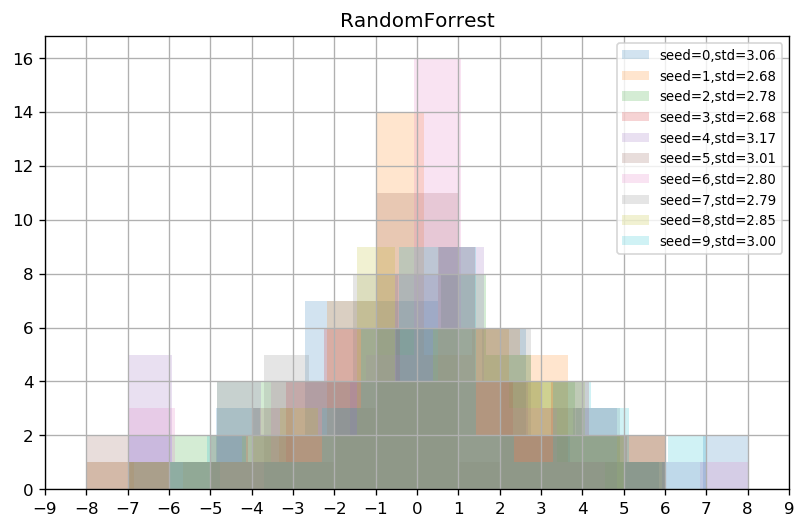

In [17]:
assessment = get_assessment(model,plot=True,title='RandomForrest')

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


# Random Forrest Model
forrest = RandomForestClassifier(
    n_estimators=200,
    random_state=1
)

# Decision tree model
tree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    random_state=2
)

# K Neighbor model
neighbor = KNeighborsClassifier(
    n_neighbors=3
) 

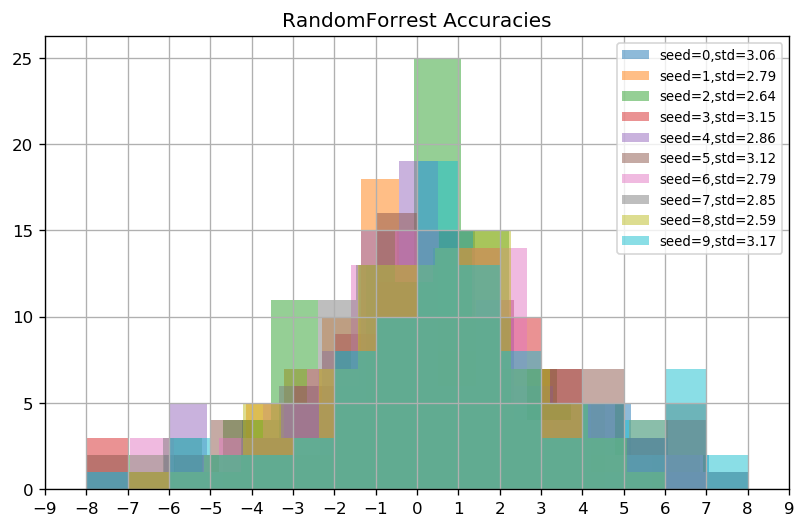

In [7]:
forrest_accuracies = get_accuracies(
    forrest,
    plot=True, 
    title='RandomForrest Accuracies')

#### Feature pruning

In [8]:
def find_optimal_features(model,remove=1,df=df,pipe=pipe_data):
    all_cols = df.columns.tolist()
    columns = all_cols[1:-1]
    id_col = all_cols[0]
    y_col = all_cols[-1] 
    feature_dict = {}
    print(len(columns))
    for i in range(len(columns)-1):
        cols = columns[:i]+columns[i+remove:]
        Xi,yi = pipe(df[[id_col]+cols+[y_col]])
        accuracies = get_accuracies(model)
        feature_dict[i] = accuracies
    return feature_dict

In [14]:

# tree_feature_dict = find_optimal_features(tree)


# for i in range(len(df.columns)-3):
#     for acc in tree_feature_dict[i]:
#         print(acc.std())

#### Hyperparameter optimization

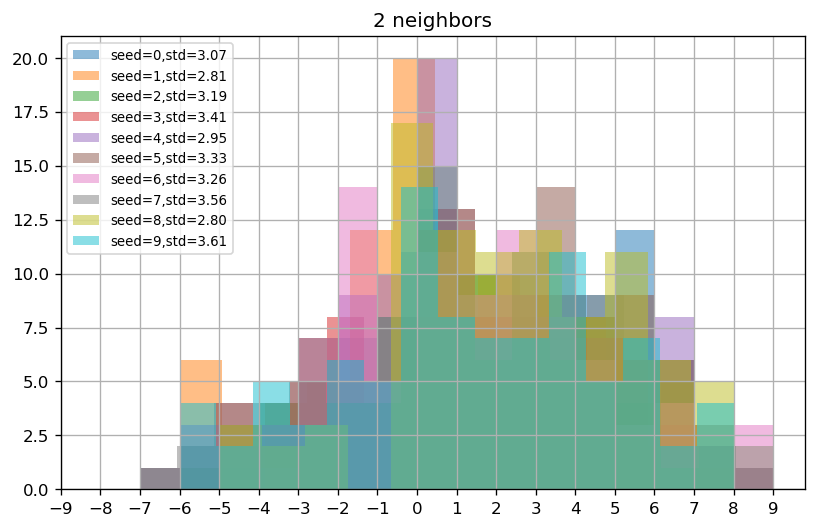

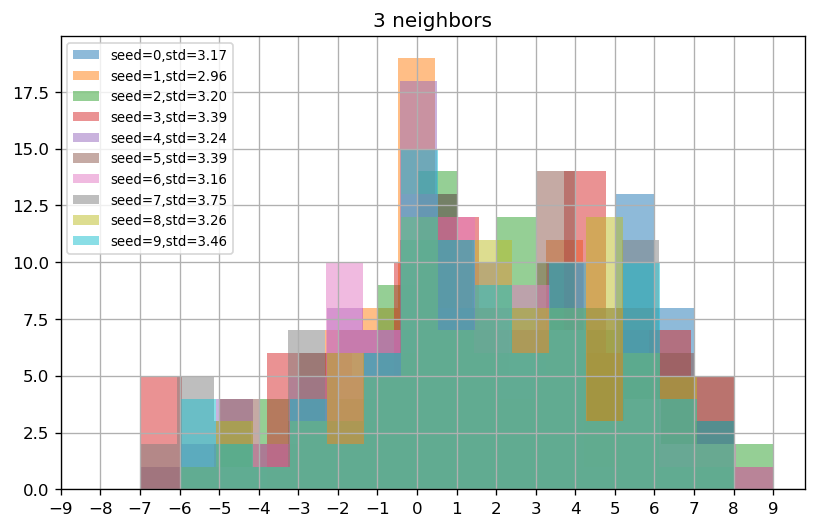

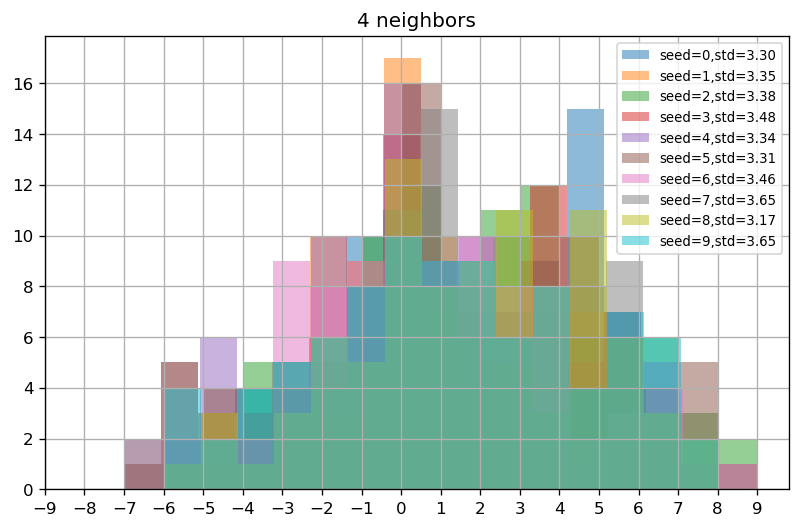

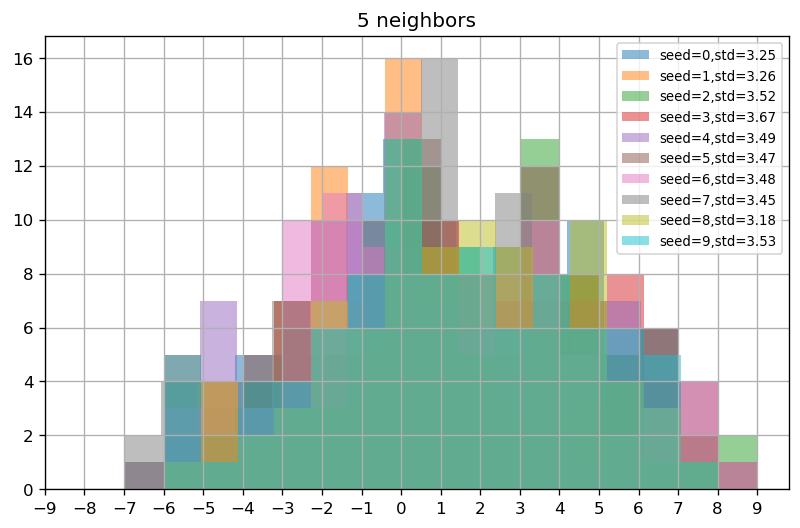

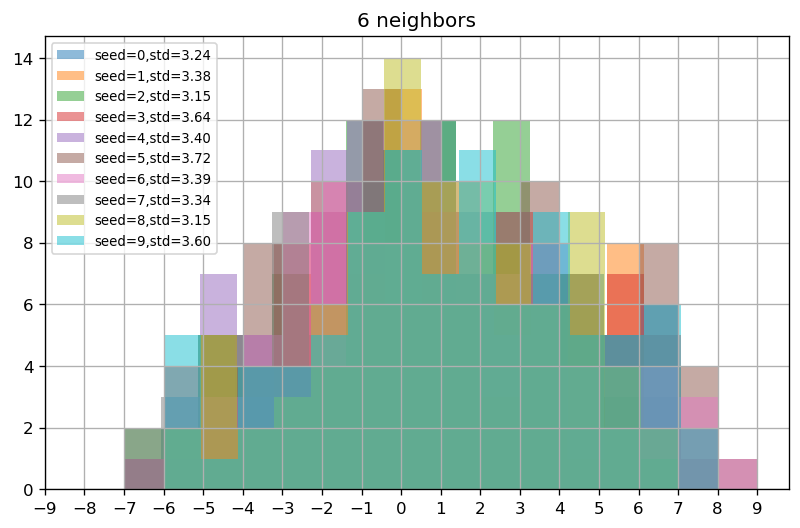

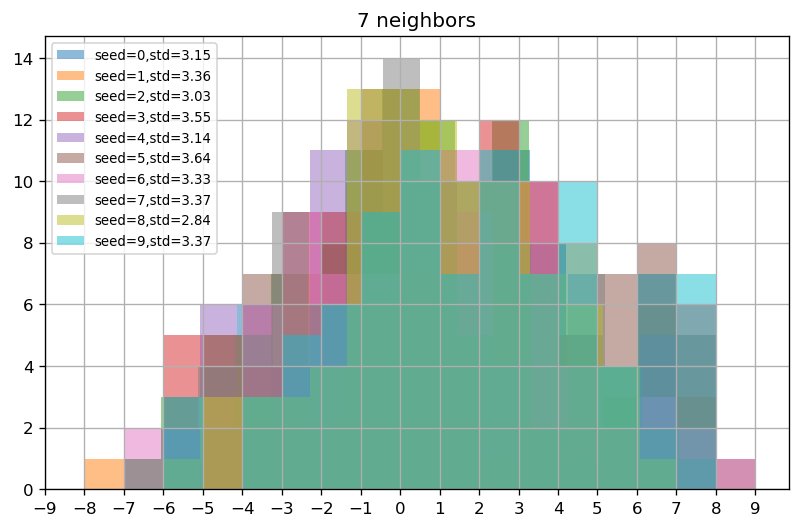

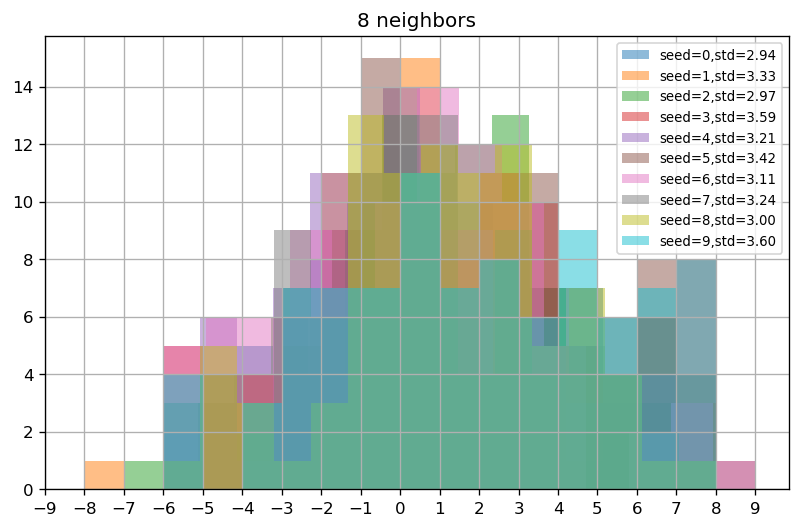

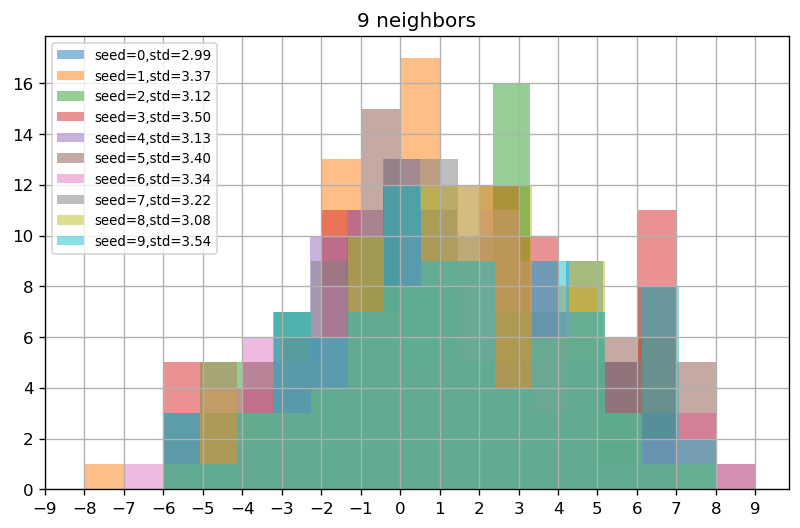

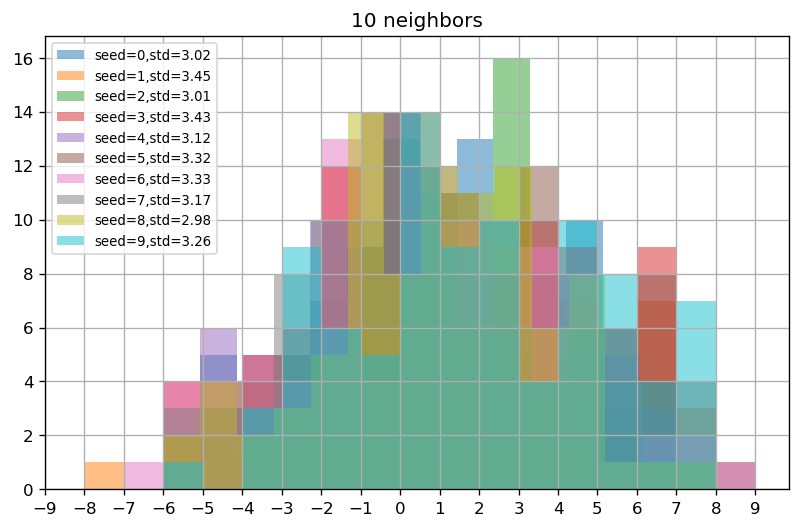

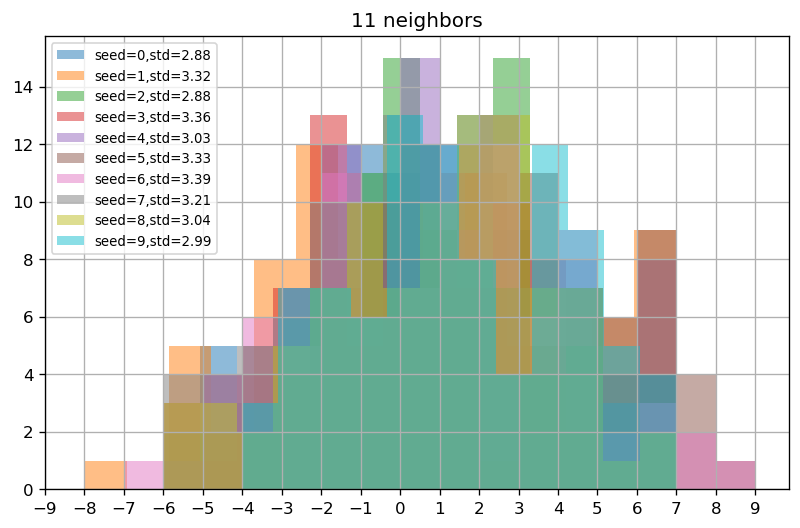

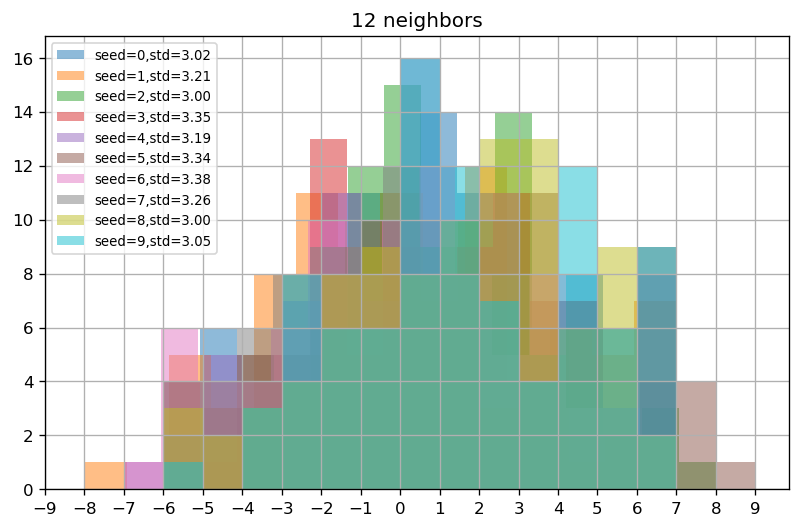

In [16]:
for i in range(2,13):
    model = KNeighborsClassifier(n_neighbors=i)
    acc = get_accuracies(model,plot=True,title='{} neighbors'.format(i))
    

### Results

--

To quantify what can already be seen visually above, lets take the standard deviation of our sample means for each model's accuracy distribution:



In [30]:
# List of our accuracy arrays
model_accuracies = [forrest_accuracies,tree_accuracies,neighbor_accuracies]

def get_results(model_accuracies):
    # Loop over all model accuracies
    result_metrics = []
    for i,accuracies in enumerate(model_accuracies):
        # Find average mean and standard deviation for accuracy distributions
        avg = sum([acc.mean() for acc in accuracies])/N
        std = sum([acc.std() for acc in accuracies])/N
        # Append metrics to our list
        result_metrics.append([avg,std])
    return np.array(result_metrics)

In [31]:
results = get_results(model_accuracies)
print("Avg/Std for model accuracies (lower is better):\n",results)

Avg/Std for model accuracies (lower is better):
 [[ 1.53888889e-01  2.78788607e+00]
 [-2.77777778e-03  3.04144544e+00]
 [ 1.41555556e+00  3.24002574e+00]]


In [0]:
print(result_metrics)

[(0.10555555555555546, 2.80605435457701), (0.16277777777777783, 3.064440648872339), (1.437944444444446, 3.1974725376916435)]


We can see that our accuracy averages are around zero for the tree and forrest models, meaning that these model's guessed a person's income to be higher or lower than ground truth a roughly equal amount, as opposed to the neighbors model which had an average guess accuracy of +1.4.

However, more consequential metric here is the standard deviation. We have greater that 2.5 $\sigma$ values for each model meaning that it cannot reliably predict income according to our standard.

### Conclusion

Perhaps these models could succeed with a greater number of samples or more personal metrics, but under the present circumstances none of our models attained statistically significant results for income prediciton.